In [1]:
import torch
import csv
from collections import namedtuple
import numpy as np
import os 
import pandas as pd
from PIL import Image
from IPython.display import display  


In [31]:
CELEBA_PATH = '/Users/victorbarberteguy/Desktop/Master2/MVA/PGM/ccvae_pytorch/data/datasets/celeba/celeba/'
CSV = namedtuple("CSV", ["header", "index", "data"])
hair_attributes = ['Bald','Black_Hair','Blond_Hair','Brown_Hair','Gray_Hair']

We load the list of attributes and the list where the dataset is partitioned

In [22]:
with open(os.path.join(CELEBA_PATH, 'list_attr_celeba.txt')) as csv_file:
        data = list(csv.reader(csv_file, delimiter=" ", skipinitialspace=True))
headers = data[1]
data = data[1 + 1 :]
indices = [row[0] for row in data]
data = [row[1:] for row in data]
data_int = [list(map(int, i)) for i in data]
attr = CSV(headers, indices, torch.tensor(data_int))

In [23]:
with open(os.path.join(CELEBA_PATH, 'list_eval_partition.txt')) as csv_file:
        data = list(csv.reader(csv_file, delimiter=" ", skipinitialspace=True))
data = data[:]
indices = [row[0] for row in data]
id_partition = [row[1:][0] for row in data]
eval_df = pd.DataFrame(id_partition, index = indices)

## Analysis of the hair labels

In [24]:
hair_attr_index = []
for attributes in hair_attributes:  
    hair_attr_index.append(attr[0].index(attributes))

data = attr[2][:,hair_attr_index]
df_attr = pd.DataFrame(data,columns=hair_attributes, index=attr[1])

In [25]:
df_attr.head()

,Bald,Black_Hair,Blond_Hair,Brown_Hair,Gray_Hair
000001.jpg,-1,-1,-1,1,-1
000002.jpg,-1,-1,-1,1,-1
000003.jpg,-1,-1,-1,-1,-1
000004.jpg,-1,-1,-1,-1,-1
000005.jpg,-1,-1,-1,-1,-1


In [26]:
df_attr[df_attr <= 0] =  0
attributes_per_sample = np.bincount(df_attr.sum(axis=1))
print('Repartition of hair attributes')
print(f"\t{attributes_per_sample[0]} samples don't have any hair-color attributes")
print(f"\t{attributes_per_sample[1]} samples have exactly one hair-color attribute")
print(f"\t{sum(attributes_per_sample[2:])} samples have more than one hair-color attribute")

Repartition of hair attributes
	73619 samples don't have any hair-color attributes
	124892 samples have exactly one hair-color attribute
	4088 samples have more than one hair-color attribute


## Creation of a Hair multi-class label

In [27]:
# Keep only images with exactly one hair color
df_attr = pd.DataFrame(attr[2],columns=headers[:-1], index=attr[1])
df_hair_attr = df_attr[hair_attributes]
df_attr = df_attr.drop(hair_attributes, axis = 1)

df_hair_attr[df_hair_attr <= 0] =  0
df_one_hair_attr = df_hair_attr[df_hair_attr.sum(axis=1) == 1]

len(df_one_hair_attr)

124892

In [28]:
# Create new label
df_new_hair_attr = pd.DataFrame(data = (df_one_hair_attr*[0,1,2,3,4]).sum(axis=1).astype(int), columns = ['Hair'], index = df_one_hair_attr.index)
new_headers = headers.copy()
for attribute in hair_attributes:
    new_headers.remove(attribute) 
new_headers.insert(-1,'Hair')
new_headers.remove('')

In [29]:
df_new_attr = df_attr.join(df_new_hair_attr, how = 'inner')
df_new_attr = df_new_attr[new_headers]
df_new_attr

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bangs,Big_Lips,Big_Nose,Blurry,Bushy_Eyebrows,Chubby,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,Hair
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,3
000002.jpg,-1,-1,-1,1,-1,-1,1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,3
000006.jpg,-1,1,1,-1,-1,1,-1,-1,-1,-1,...,-1,-1,1,1,-1,1,-1,-1,1,3
000007.jpg,1,-1,1,1,-1,1,1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,1,1
000008.jpg,1,1,-1,1,-1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,-1,-1,1,-1,-1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,2
202596.jpg,-1,-1,-1,-1,1,1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,1,2
202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,1
202598.jpg,-1,1,1,-1,-1,1,-1,-1,1,-1,...,1,-1,1,1,-1,1,-1,-1,1,1


Sample of Celeba with Brown_Hair


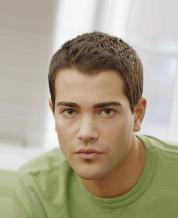

In [32]:
# Test 
row = df_new_attr.sample()
hair_id = row['Hair'].values.item()


rand_id = row.index.values.item()
image = Image.open(CELEBA_PATH+'img_align_celeba/'+rand_id)
print('Sample of Celeba with '+ hair_attributes[int(hair_id)])
display(image)

### Delete the other images from the list of partitioning

In [33]:
df_new_eval = pd.DataFrame(data = eval_df, index = df_new_attr.index)
df_new_eval.head(5)


,0
000001.jpg,0
000002.jpg,0
000006.jpg,0
000007.jpg,0
000008.jpg,0


In [34]:
len(df_new_eval)

124892

## Same transform for other text files

In [35]:
with open(os.path.join(CELEBA_PATH, 'identity_CelebA.txt')) as csv_file:
        data = list(csv.reader(csv_file, delimiter=" ", skipinitialspace=True))
data = data[:]
indices = [row[0] for row in data]
id_partition = [row[1:][0] for row in data]
identity_df = pd.DataFrame(id_partition, index = indices)

df_new_identity = pd.DataFrame(data = identity_df, index = df_new_attr.index)
df_new_identity.head(5)

,0
000001.jpg,2880
000002.jpg,2937
000006.jpg,4153
000007.jpg,9040
000008.jpg,6369


In [36]:
with open(os.path.join(CELEBA_PATH, 'list_bbox_celeba.txt')) as csv_file:
        data = list(csv.reader(csv_file, delimiter=" ", skipinitialspace=True))
headers = data[1]
data = data[1 + 1 :]
indices = [row[0] for row in data]
id_partition = [row[1:][0] for row in data]
bbox_df = pd.DataFrame(id_partition, index = indices)

df_new_bbox = pd.DataFrame(data = bbox_df, index = df_new_attr.index)
df_new_bbox.head(5)

,0
000001.jpg,95
000002.jpg,72
000006.jpg,146
000007.jpg,64
000008.jpg,212


In [37]:
with open(os.path.join(CELEBA_PATH, 'list_landmarks_align_celeba.txt')) as csv_file:
        data = list(csv.reader(csv_file, delimiter=" ", skipinitialspace=True))
data = data[1+1:]
indices = [row[0] for row in data]
id_partition = [row[1:][0] for row in data]
landmark_df = pd.DataFrame(id_partition, index = indices)

df_new_landmark = pd.DataFrame(data = landmark_df, index = df_new_attr.index)
df_new_landmark.head(5)

,0
000001.jpg,69
000002.jpg,69
000006.jpg,71
000007.jpg,70
000008.jpg,71


## Save files

In [71]:
output_file_path = os.path.join(CELEBA_PATH, 'list_attr_multiclass_celeba.txt')

with open(output_file_path, 'w') as file:
    file.write("202599"+"\n")
    file.write(" ".join(new_headers) + "\n")
    for index, row_data in zip(df_new_attr.index,df_new_attr.values):
        row_str = " ".join([str(index)] + list(map(str, row_data.tolist())))
        file.write(row_str + "\n")

In [72]:
eval_file_path = os.path.join(CELEBA_PATH, 'list_eval_partition_multiclass.txt')

with open(eval_file_path, 'w') as file:
    for index, row_data in zip(df_new_eval.index,df_new_eval.values):
        row_str = " ".join([str(index)] + list(map(str, row_data.tolist())))
        file.write(row_str + "\n")

In [38]:
identity_file_path = os.path.join(CELEBA_PATH, 'identity_multiclass_CelebA.txt')

with open(identity_file_path, 'w') as file:
    for index, row_data in zip(df_new_eval.index,df_new_identity.values):
        row_str = " ".join([str(index)] + list(map(str, row_data.tolist())))
        file.write(row_str + "\n")

In [39]:
bbox_file_path = os.path.join(CELEBA_PATH, 'list_bbox_multiclass_celeba.txt')

with open(bbox_file_path, 'w') as file:
    file.write("202599"+"\n")
    file.write(" ".join(new_headers) + "\n")
    for index, row_data in zip(df_new_attr.index,df_new_bbox.values):
        row_str = " ".join([str(index)] + list(map(str, row_data.tolist())))
        file.write(row_str + "\n")

In [40]:
landmark_file_path = os.path.join(CELEBA_PATH, 'list_landmarks_align_multiclass_celeba.txt')

with open(landmark_file_path, 'w') as file:
    file.write("202599"+"\n")
    file.write(" ".join(new_headers) + "\n")
    for index, row_data in zip(df_new_attr.index,df_new_landmark.values):
        row_str = " ".join([str(index)] + list(map(str, row_data.tolist())))
        file.write(row_str + "\n")